In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow import keras
import sklearn.metrics
import io
import itertools
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import drive
%matplotlib inline
%load_ext tensorboard

In [2]:
print(tf.__version__)
print(tfds.__version__)

2.12.0
4.9.2


In [3]:
drive.mount('/content/drive')
DATASET_DIR = '/content/drive/MyDrive/DATASETS'
BATCH_SIZE = 32
IMG_HEIGHT = 300
IMG_WIDTH = 300
SHUFFLE_VALUE = True
AUTOTUNE = tf.data.AUTOTUNE

Mounted at /content/drive


### DATASET PREPROCESSING

In [4]:
# Make Train Dataset
train_ds = keras.utils.image_dataset_from_directory(
    directory=DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=345,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VALUE
)

# Make Val Dataset
val_ds = keras.utils.image_dataset_from_directory(
    directory=DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=345,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VALUE
)

# Make Test Dataset
val_batches = tf.data.experimental.cardinality(dataset=val_ds)
test_ds = val_ds.take((1 * val_batches) // 2)
val_ds = val_ds.skip((1 * val_batches) // 2)

print('\nSPLITTING VALIDATION FOR TESTING:')
print(f'Using {tf.data.experimental.cardinality(dataset=val_ds) * BATCH_SIZE} files for validation')
print(f'Using {tf.data.experimental.cardinality(dataset=test_ds) * BATCH_SIZE} files for testing')


Found 8887 files belonging to 13 classes.
Using 7110 files for training.
Found 8887 files belonging to 13 classes.
Using 1777 files for validation.

SPLITTING VALIDATION FOR TESTING:
Using 896 files for validation
Using 896 files for testing


In [5]:
class_names = train_ds.class_names
print(class_names)

['Jagung_Bercak_Daun', 'Jagung_Hawar_Daun', 'Jagung_Karat_Daun', 'Jagung_Sehat', 'Kentang_Bercak_Kering', 'Kentang_Busuk_Daun', 'Kentang_Sehat', 'Kentang_Virus', 'Padi_Bercak_Cokelat', 'Padi_Blast', 'Padi_Hawar_Daun', 'Padi_Hispa', 'Padi_Sehat']


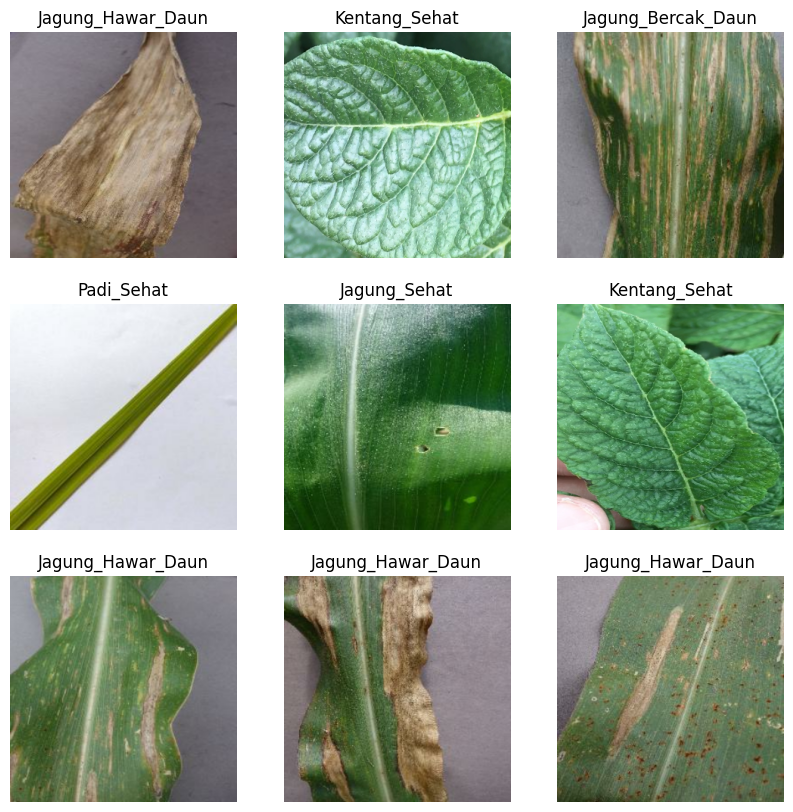

In [6]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'), 
  tf.keras.layers.RandomRotation(factor=0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomBrightness(factor=[-0.3,0.3]),
  tf.keras.layers.RandomContrast(factor=0.2)
])

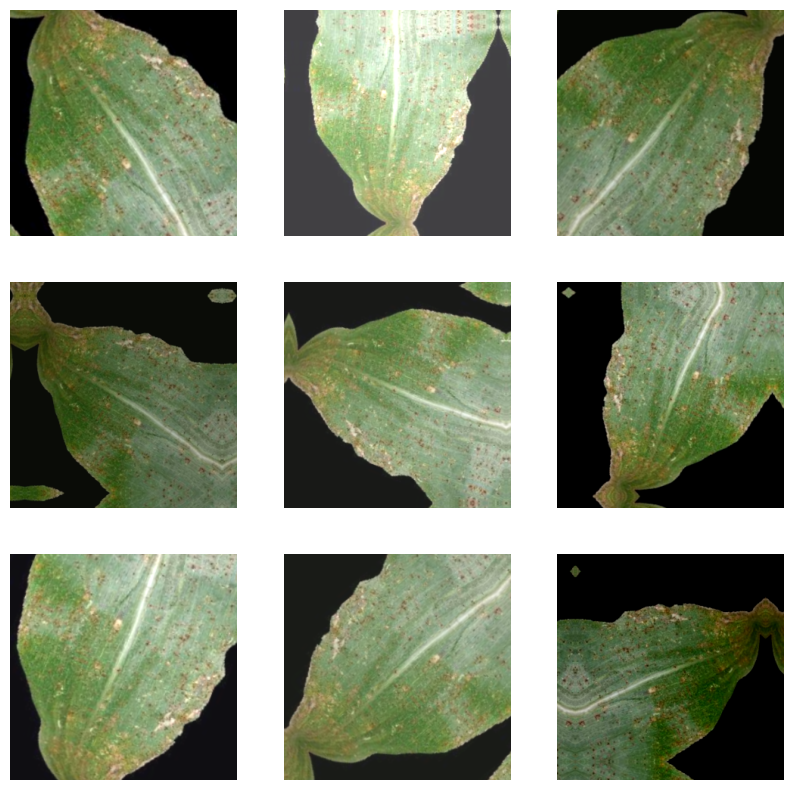

In [15]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [16]:
train_ds = train_ds.cache().shuffle(buffer_size=100 * BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### CONFUSION MATRIX

In [23]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [ ]:
class myCallback(keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') is not None and logs.get('accuracy') > 0.97:                 
                print("\nReached 98% accuracy so cancelling training!")
                
                # Stop training once the above condition is met
                self.model.stop_training = True

callbacks = myCallback()

### MODEL

In [17]:
base_model = tf.keras.applications.EfficientNetB3(input_shape=(300,300,3), include_top=False, weights='imagenet')
base_model.trainable = True

43941136/43941136 [==============================] - 0s 0us/step


In [18]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  385


In [19]:
# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [20]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(300,300,3)),
    data_augmentation,
    base_model,
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(13, activation='softmax')
])

In [21]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 32)          442400    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                  

In [22]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
#Evaluate Our Final Model Architectures
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)


In [ ]:
class myCallback(keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') is not None and logs.get('accuracy') > 0.97:                 
                print("\nReached 98% accuracy so cancelling training!")
                
                # Stop training once the above condition is met
                self.model.stop_training = True

callbacks = myCallback()

In [ ]:
history_ft = model.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds, 
                    callbacks=[callbacks])

Epoch 1/50
223/223 [==============================] - 155s 503ms/step - loss: 1.2377 - accuracy: 0.5887 - val_loss: 0.4361 - val_accuracy: 0.8400
Epoch 2/50
223/223 [==============================] - 112s 500ms/step - loss: 0.5081 - accuracy: 0.8269 - val_loss: 0.3110 - val_accuracy: 0.8842
Epoch 3/50
223/223 [==============================] - 113s 501ms/step - loss: 0.3846 - accuracy: 0.8672 - val_loss: 0.2551 - val_accuracy: 0.9092
Epoch 4/50
223/223 [==============================] - 113s 501ms/step - loss: 0.3202 - accuracy: 0.8861 - val_loss: 0.2646 - val_accuracy: 0.9149
Epoch 5/50
223/223 [==============================] - 112s 500ms/step - loss: 0.2849 - accuracy: 0.9017 - val_loss: 0.2399 - val_accuracy: 0.9149
Epoch 6/50
223/223 [==============================] - 112s 499ms/step - loss: 0.2517 - accuracy: 0.9122 - val_loss: 0.2347 - val_accuracy: 0.9285
Epoch 7/50
223/223 [==============================] - 113s 505ms/step - loss: 0.2290 - accuracy: 0.9197 - val_loss: 0.2186 -

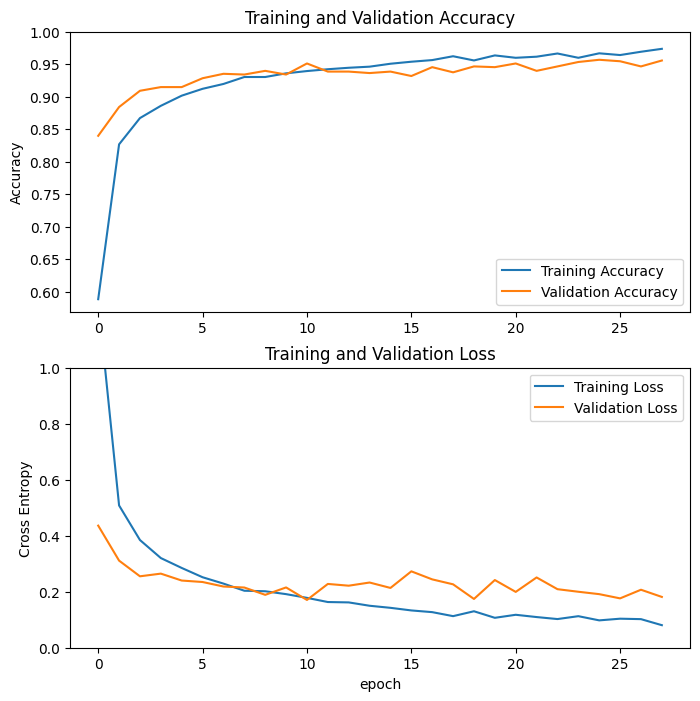

In [ ]:
acc = history_ft.history['accuracy']
val_acc = history_ft.history['val_accuracy']

loss = history_ft.history['loss']
val_loss = history_ft.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

28/28 [==============================] - 7s 206ms/step - loss: 0.1787 - accuracy: 0.9520
Test accuracy : 0.9520089030265808


In [ ]:
test_data = list(test_ds)
features = np.concatenate([test_data[n][0] for n in range(0, len(test_data))])
targets = np.concatenate([test_data[n][1] for n in range(0, len(test_data))])

In [ ]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [ ]:
predictions = probability_model.predict(features)

28/28 [==============================] - 9s 188ms/step


Predictions:
 [[0.06794275 0.18468706 0.06794285 ... 0.06794277 0.06794274 0.06794274]
 [0.06794272 0.06794272 0.06794272 ... 0.06794272 0.06794272 0.06794272]
 [0.06794305 0.06794305 0.06794305 ... 0.0679431  0.06794305 0.06794305]
 ...
 [0.06880217 0.06879938 0.06880113 ... 0.06881774 0.07740815 0.06889302]
 [0.06794274 0.06794274 0.06794274 ... 0.06794274 0.06794274 0.06794274]
 [0.06794976 0.06794974 0.06794975 ... 0.06795035 0.06794975 0.06794973]]
Labels:
 [ 1  4  7  2  3 12  7  4  9  2 12  1  2  2 10  1  1  1  6  9  2  2  1  2
  2  2  7  6  0  0  1  2  6  5  2  2  2 11  8  8 10  0  2 12 12  2  5  1
  2  3  1  2  8  4  2  6  1  8  4  3  6  2  7  1  7  2  3  9 11  9  6  0
  9 12  9 12  8  2  6 11 12  6 12  2 12  7  6 10  3  3 10  4  9  8  5  1
  2  5  3 11  1  6  8  3  8  8  1  6  2  5  2 11  7  3  6  3  1  2  3  1
 10  6  2  3  8  8  1  1  3  5  1  3 10  7  4  7 10  7  9  3 12  1  0  0
 12  0  1  2  1  9  3  2 11  5  6  8  6  2  1 10  7  2  0  1 11  0 10  6
  2 12  8  8  2  0  9 

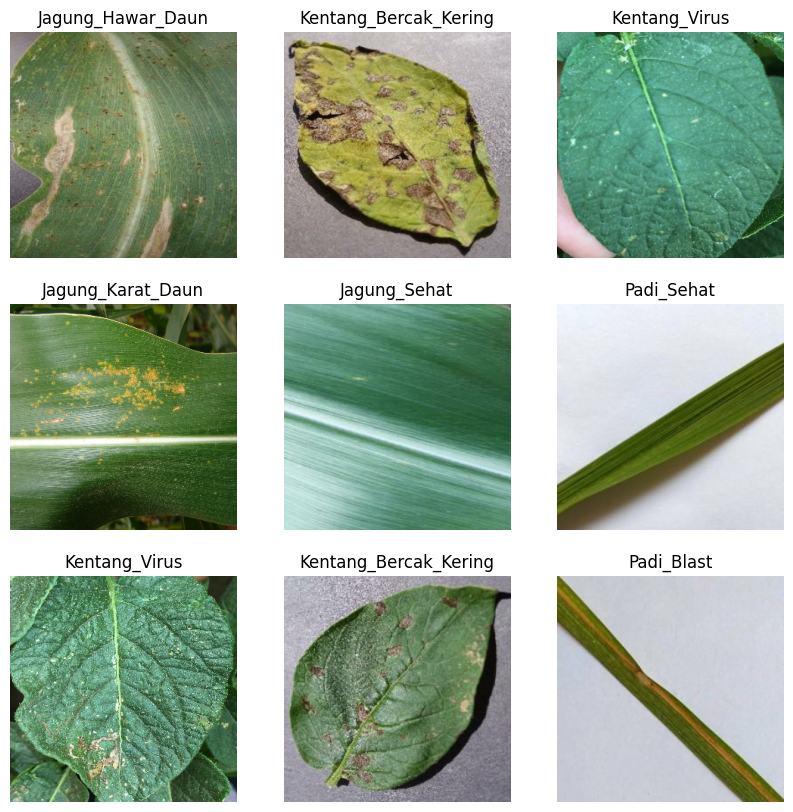

In [ ]:
print('Predictions:\n', predictions)
print('Labels:\n', targets)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(features[i].astype("uint8"))
 
  plt.title(class_names[np.argmax(predictions[i])])
  plt.axis("off")